In [1]:
import matplotlib.pyplot as plt
import glob
import os as os

import numpy as np
import itertools

from scipy import ndimage
from matplotlib.colors import LogNorm

In [7]:
from tensorflow import keras # Need this when working in a Jupyter notebook

from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


from keras import backend as K
from keras.models import Sequential # Model used to create the architecture both ANNs and CNNs
from keras.layers.core import Dense 
# from keras.optimizers import SGD 
from tensorflow.keras.optimizers import SGD # Use the above instead in GCP. Colab can use the previous line.
from keras.layers.convolutional import Conv2D # For CNNs
from keras.layers.convolutional import MaxPooling2D # For CNNs
from keras.layers.core import Flatten # For CNNs
from keras.layers.core import Activation # For CNNs
from keras.layers.core import Dropout # For CNNs

from PIL import Image # image resizing

# Accessing the GCS bucket with the images

*Done in the terminal*

Listing availble buckets:

`gsutil ls`

Creating folder in the jupyterlab directory for the bucket to be mounted: 

`cd ~/` *This should take you to /home/jupyter/*

`mkdir -p gcs` *Create a folder that will be used as a mount point*

Mounting the bucket from gcs into the newly created folder (static mount):

`gcsfuse --only-dir foldername/ my-bucket /mount/point` with '/mount/point' being the mounting point you want in the jupyterlab directory, 'my-bucket' being the name of the bucket you would like to mount/ 

or

`gcsfuse goyo-images gcs` 
But this doesn't do anything...

## Solved 

I was using the [these instructions](https://cloud.google.com/blog/topics/developers-practitioners/cloud-storage-file-system-vertex-ai-workbench-notebooks) and the `implicit-dirs` command in the terminal needed the bucket name and the mounting point. I disregard the other instructions. 

I listed the available buckets to ensure my bucket was there, `cd` to root directory, created a folder for the mount point, then used `gcsfusee --implicit-dirs bucket-name mount-point` and the bucket was mounted. 

Made a new VM instance on GCP with more RAM to perform the above and worked on the initial attempt. 

## Continuing on

Resource monitoring done in the terminal with 

cpu `htop`

gpu `nvidia-smi`

In [7]:
dataDir = 'gcs/2020_2022/2020~2022 edited' # Copied bucket path from gcs

`cd` to root directory so we can access the gcs

In [4]:
cd ~/

/home/jupyter


In [5]:
ls

IG-Trends-with-Machine-Learning/  gcs/  src/  tutorials/


In [8]:
os.listdir(dataDir)

['dragon_snake', 'flower', 'fox_tiger', 'mix', 'small_animal']

In [9]:
objects = os.listdir(dataDir)
objects

['dragon_snake', 'flower', 'fox_tiger', 'mix', 'small_animal']

In [10]:
def globFn(objects: str):
    #stores the file names in a list
    imageFilenames = glob.glob(dataDir + '/' + objects + '/' + objects + '_*.jpg') # Where the asterisk symbol acts as a wildcard
    return imageFilenames

Displaying a single image from the glob function

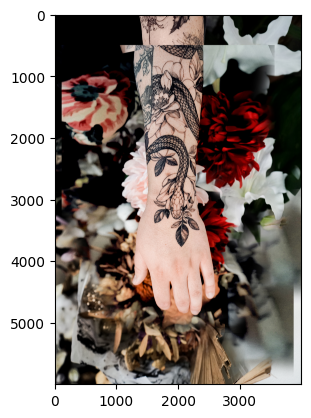

In [11]:
plt.imshow(plt.imread(globFn(objects[0])[0]))

**TASK / ISSUE** We should consider the spread of image sizes, some images will have different dimensions as others. 

In [26]:
test_flower_image = plt.imread(globFn(objects[1])[0])

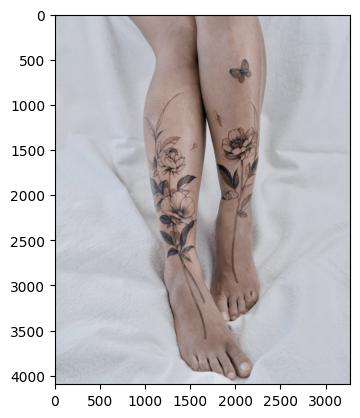

In [27]:
plt.imshow(test_flower_image)

Storing the filenames

In [14]:
birdFiles = globFn('bird')
dragon_snakeFiles = globFn('dragon_snake')
flowerFiles = globFn('flower')
mixFiles = globFn('mix')
small_animalsFiles = globFn('small_animals')
fox_tigerFiles = globFn('fox_tiger')

Reading the filenames and storing the data

In [16]:
bird = []
for filename in birdFiles:
  bird.append(plt.imread(filename))

dragon_snake = []
for filename in dragon_snakeFiles:
  dragon_snake.append(plt.imread(filename))

flower = []
for filename in flowerFiles:
  flower.append(plt.imread(filename))

mix = []
for filename in mixFiles:
  mix.append(plt.imread(filename))

small_animals = []
for filename in small_animalsFiles:
  small_animals.append(plt.imread(filename))

fox_tiger = []
for filename in fox_tigerFiles:
  fox_tiger.append(plt.imread(filename))

Consider saving these new arrays, so that they don't have to be rerun everytime there's a new kernel. [help here](https://machinelearningmastery.com/how-to-save-a-numpy-array-to-file-for-machine-learning/#:~:text=You%20can%20save%20your%20NumPy,file%2C%20most%20commonly%20a%20comma.)

Best to normalise and flatten the image for neural networks. First doing this on the test flower image

In [28]:
normalised = (test_flower_image-np.min(test_flower_image))/np.max(test_flower_image-np.min(test_flower_image))
flattened = normalised.flatten()

In [29]:
normalised.shape

(4096, 3276, 3)

In [30]:
flattened.shape

(40255488,)

Huge image size, received help from Python server on Discord advising the size is too big. Should consider resizing to 224x224 as this is the typical size for training images. 

# Resizing the images

In [8]:
test_flower_image_resize = test_flower_image.resize((224, 224))
# new_image.save('myimage_500.jpg')

NameError: name 'test_flower_image' is not defined

Above cell took a long time to run, consider multi threading. 

In [ ]:
plt.imshow(test_flower_image_resize)

materials: 

[resize](https://cloudinary.com/guides/bulk-image-resize/python-image-resize-with-pillow-and-opencv)
[multi thread](https://cloud.google.com/kubernetes-engine/docs/how-to/configure-smt)
[kaggle resize](https://www.kaggle.com/code/jhoward/resize-images)
[github resize](https://github.com/fastai/fastai/blob/8511edd8f10399264e5158325e79d5e92ef2cc3f/fastai/vision/utils.py#L93)

# Binarizing the labels

In [34]:
stackedArrayLabels = []
stackedArrayLabels.append(objects[1])
print(stackedArrayLabels)

lb = LabelBinarizer()
binarizedLabels = lb.fit_transform(stackedArrayLabels)
print(binarizedLabels)
print(objects)

['flower']
[[0]]
['dragon_snake', 'flower', 'fox_tiger', 'mix', 'small_animal']


The binarized label doesn't work as intended because there's only one image to binarize it's label. If all images were included in the binarization then the binarized labels should look like 

$\big[$0, 1, 0, 0, 0$\big]$

In [ ]:
stackedArrayValues = [] # Normalised, resized and stacked 1D arrays corresponding to the images.
stackedArrayLabels = [] # 1D array for the labels.

# Finding all the sources in each object that ends with `imageType_*.jpg`.
for imageType in objects:
    folder = os.path.abspath(dataDir + '/' + imageType)
    files = glob.glob(folder + '/' + imageType + '_*.jpg')

# For each source, we want to resize and normalise the image.
    for filename in files:
        data = plt.imread(filename)

        # Normalisation is done by first subtracting the minimum value, and then dividing by the maximum value in the subtracted values.
        normalisedData = (data - np.min(data))/np.max(data - np.min(data))
        normalised1D = normalisedData.flatten() # Turning the 2D image into a 1D array.
        stackedArrayValues.append(normalised1D)
        stackedArrayLabels.append(imageType)
    print(f'object {imageType} complete')
# Converting the lists into a 1D array.
stackedArrayValues = np.array(stackedArrayValues)
stackedArrayLabels = np.array(stackedArrayLabels)

# Binarising the labels once all the sources for each object were identified, resized and normalised:
lb = LabelBinarizer()
binarizedLabels = lb.fit_transform(stackedArrayLabels)

# ANN model

In [ ]:
files

In [ ]:
stackedArrayValues = [] # Normalised, resized and stacked 1D arrays corresponding to the images.
stackedArrayLabels = [] # 1D array for the labels.

# Finding all the sources in each object that ends with `_I4.fits`.
folder = os.path.abspath(dataDir + '/' + objects[0])
files = glob.glob(folder + '/' + objects[0] + '_*.jpg')

# For each source, we want to resize and normalise the image.
for filename in files:
  data = plt.imread(filename)
  # resizeData = ndimage.zoom(data,zoom=zoom_factor) 

  # Normalisation is done by first subtracting the minimum value, and then dividing by the maximum value in the subtracted values.
  normalisedData = (data-np.min(data))/np.max(data-np.min(data))
  normalised1D = normalisedData.flatten() # Turning the 2D image into a 1D array.
  stackedArrayValues.append(normalised1D)
  stackedArrayLabels.append(imageType)

# Converting the lists into a 1D array.
stackedArrayValues = np.array(stackedArrayValues)
stackedArrayLabels = np.array(stackedArrayLabels)

# Binarising the labels once all the sources for each object were identified, resized and normalised:
lb = LabelBinarizer()
binarizedLabels = lb.fit_transform(stackedArrayLabels)

In [ ]:
dataPrepANN

# CNN model

for cnn have to consider the astro objects had 3 different wavelenghts for each image

In [ ]:
def cnnPrepFn(directory, source_type, rotation_factor):
  # Similar initial process as the ANN function:
  files = glob.glob(directory + '/' + source_type+'/'+'*_I4.fits')
  # The amount of zooming for the images will impact the image's dimensions.
  # Since 302x302 is the original size of the images, we want the dimension of the zoomed-in images which depends on the zoom factor.
  imagesArr = np.zeros((100,int(zoom_factor*302),int(zoom_factor*302),3)) 
  labelsList = [] # The labels will become a 1D array.

  # Identifying the 3 images that will be resized and normalised:
  for indx in np.arange(0,len(files)):
    source = files[indx].split('_I4.fits')[0] # Finding the name for each source by splitting the string from `glob.glob` into two parts.
                                              # We don't want the text starting from _, so we use [0] to get the source name only.
    i2Image = plt.imread(source+'_I2.fits') # The I2 image for the source.

    # Resizing the three Spitzer-band images above and finding the maximum value in each image:
    resizeI2 = ndimage.rotate(i2Image, rotation_factor, reshape = False)
    resizeI2Max = np.max(resizeI2)


    # Normalisation is done by finding the greatest value in the maxima for each of the 3 images.
    # This is so all the values are smaller than or equal to 1 (for the CNN), and maintain the colour differences between them.
    normFactor = np.max([resizeI2Max, resizeI3Max, resizeI4Max])

    # Applying the normalisation factor to the resized images:
    normI2 = resizeI2/normFactor

    # Adding the resized and normalised images into the iamge array:
    imagesArr[indx,:,:,0] = normI2

    # Adding the label that identifies the source type (HII, PNE, RG):
    labelsList.append(source_type)

  # Converting the list of labels into an array:
  labelsArr = np.array(labelsList)

  return imagesArr, labelsArr

In [ ]:
HII_Images_0, HII_Labels_0 = cnnPrepFn2(dir, "HII", zoom_factor=0.6, rotation_factor= 0)
PNE_Images_0, PNE_Labels_0 = cnnPrepFn2(dir, "PNE", zoom_factor=0.6, rotation_factor= 0)
RG_Images_0, RG_Labels_0 = cnnPrepFn2(dir, "RG", zoom_factor=0.6, rotation_factor= 0)

In [ ]:
combined_img_aug = np.concatenate((HII_Images_0, HII_Images_90, HII_Images_180, HII_Images_270, PNE_Images_0, PNE_Images_90, PNE_Images_180, PNE_Images_270, RG_Images_0, RG_Images_90, RG_Images_180, RG_Images_270), axis = 0)
combined_labels_aug = np.concatenate((HII_Labels_0, HII_Labels_90, HII_Labels_180, HII_Labels_270, PNE_Labels_0, PNE_Labels_90, PNE_Labels_180, PNE_Labels_270, RG_Labels_0, RG_Labels_90, RG_Labels_180, RG_Labels_270), axis = 0)

combined_img_aug.shape

In [ ]:
# Binarising the labels for the CNN:
lb = LabelBinarizer()
combined_labels_aug = lb.fit_transform(combined_labels_aug)

In [ ]:
def cnnFn(combinedImages, combinedLabels, layers: int, neurons: float, neuronsDescending: bool(), numEpochs: int, learnRate: float, momentum: float):
  '''
  layers = number of layers to add

  neurons = integer from 0.5 to 2.0. Either halving or doubling the number of neurons. 

  numEpochs = number of epochs to train the model. 
  '''
  
  trainData, testData, trainLabels, testLabels = train_test_split(combinedImages, combinedLabels, test_size=0.3)

  modelCNN = Sequential()
  size = trainData.shape[1]
  inputShape = (size, size, 3)

  chanDim = -1
  if K.image_data_format() == "channels_first":
    inputShape = (size, size, 3)
    chanDim = 1
  
  neurons = [neurons, neurons]

  modelCNN.add(Conv2D(32*neurons[0], (3,3), input_shape = inputShape))
  modelCNN.add(Activation('relu'))
  modelCNN.add(MaxPooling2D(pool_size=(2,2)))

  modelCNN.add(Conv2D(32*neurons[0], (3,3)))
  modelCNN.add(Activation('relu'))
  modelCNN.add(MaxPooling2D(pool_size=(2,2)))

  if neuronsDescending == True:
    neurons = [neurons[0]*0.5, neurons[1]*0.25]

  modelCNN.add(Conv2D(64*neurons[0], (3,3))) 
  modelCNN.add(Activation('relu'))
  modelCNN.add(MaxPooling2D(pool_size=(2,2)))

  if layers == 1:
    modelCNN.add(Conv2D(64*neurons[1], (3,3))) 
    modelCNN.add(Activation('relu'))
    modelCNN.add(MaxPooling2D(pool_size=(2,2)))

  if layers == 2:
    modelCNN.add(Conv2D(64*neurons[1], (3,3))) 
    modelCNN.add(Activation('relu'))
    modelCNN.add(MaxPooling2D(pool_size=(2,2)))

  modelCNN.add(Flatten()) 
  modelCNN.add(Dense(64))
  modelCNN.add(Activation('relu'))
  modelCNN.add(Dropout(0.5))

  nClasses = 3
  modelCNN.add(Dense(nClasses))
  modelCNN.add(Activation('softmax'))

  # Optimiser and compiler
  opt = SGD(learning_rate= learnRate, momentum= momentum)

  modelCNN.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  batchSize = 32

  # Running the CNN model
  H = modelCNN.fit(trainData, trainLabels, 
                validation_data=(testData, testLabels),
                batch_size= batchSize, epochs = numEpochs, verbose= 0)


  # Plot the train/valid loss and train/valid accuracy 
  plot_train_curves(H.history)

  # Modelling all the test data
  predictionsCNN = modelCNN.predict(testData)
  yPred = predictionsCNN.argmax(axis=1)

  # Printing classification report
  report = classification_report(testLabels.argmax(axis=1),
                                yPred,
                                target_names=["HII","PNE","RG"])
  print(report)

  cmatrix = confusion_matrix(testLabels.argmax(axis=1), yPred)
  plot_confusion_matrix(cmatrix, classes = ['HII', 'PNE', 'RG'],
                        title = 'Classification Confusion Matrix', normalize=True)
  print(cmatrix)

# fastai and pytorch comparison